### Imports

In [1]:
import os

import numpy as np

import mne
from mne.time_frequency import psd_welch

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import cross_val_score

from matplotlib import pyplot as plt

import raw_data_loader as data_loader

In [2]:
edfs_path = "../../../dataverse_files"

## Load data

In [3]:
X, y = data_loader.load_data(edfs_path, segment_len=1.0, seed=1337)

Not setting metadata
28863 matching events found
No baseline correction applied
0 bad epochs dropped

Epochs number per patient:  [925, 910, 910, 925, 945, 930, 910, 910, 905, 1115, 915, 900, 965, 865, 845, 1145, 964, 1205, 890, 740, 1346, 911, 1185, 850, 1360, 1087, 1135, 2170]

negative:  15833
positive:  13030


### Feature Extraction (Variance)

In [4]:
np.set_printoptions(precision=50)

In [5]:
# Calculating energy for signal segments
# X = np.array([[np.sqrt(statistics.variance(channel_data)) for channel_data in epoch] for epoch in X])
X = np.array([[np.sqrt(np.var(channel_data)) for channel_data in epoch] for epoch in X])

# X = np.array([[np.var(channel_data) for channel_data in epoch] for epoch in X])

In [6]:
X.shape

(28863, 19)

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=1337)

In [8]:
print('X_train: ', X_train.shape)
print('y_train: ', y_train.shape)
print('X_test: ', X_test.shape)
print('y_test: ', y_test.shape)

X_train:  (23090, 19)
y_train:  (23090,)
X_test:  (5773, 19)
y_test:  (5773,)


### Sklearn MLP Classifier

In [9]:
from sklearn.neural_network import MLPClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
# X, y = make_classification(n_samples=100, random_state=1)
# X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y,
#                                                      random_state=1)

clf = MLPClassifier(random_state=1337, max_iter=500).fit(X_train, y_train)
# clf.predict_proba(X_test[:1])

# clf.predict(X_test[:5, :])

# clf.score(X_test, y_test)


In [10]:
train_loss_ = clf.loss_curve_

In [11]:
clf.predict_proba(X_test[:1])


array([[0.440642379755142, 0.559357620244858]])

In [12]:
y_test_pred = clf.predict(X_test)


In [13]:
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(y_test, y_test_pred)
conf_matrix

array([[   0, 2616],
       [   0, 3157]], dtype=int64)

In [17]:
clf.score(X_test, y_test)


0.5411255411255411

In [18]:
clf.loss_curve_

[0.6885784688251323,
 0.6885208951017285,
 0.6882958334486612,
 0.6881535817400631,
 0.6883029372449269,
 0.6882413157343887,
 0.6883629595405518,
 0.6881994020355074,
 0.6882807773933652,
 0.6882113944776882,
 0.6881450495520072,
 0.6882654656557682,
 0.6883181208777126,
 0.688146773473175,
 0.6881034496153715]

In [20]:
# clf.loss_curve_
clf.predict(X_test)

array([1, 1, 1, ..., 1, 1, 1])

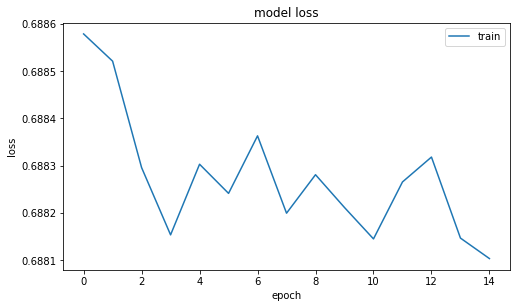

In [21]:
plt.figure(figsize=(8,10))

plt.subplot(2,1,2)
# summarize history for loss
plt.plot(train_loss_)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

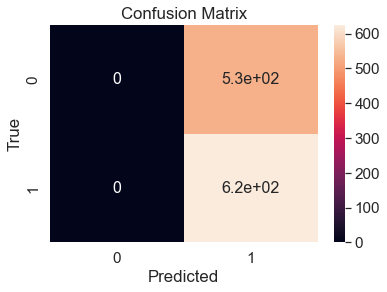

In [22]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt


# plt.figure(figsize=(10,7))
sn.set(font_scale=1.4) # for label size
sn.heatmap(conf_matrix, annot=True, annot_kws={"size": 16}) # font size


plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()